In [145]:
from camera import Camera, FakeCamera
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [146]:
cameras = [
#FakeCamera("images/img4.png"), FakeCamera("images/img1.png")]
FakeCamera("images/img6.png"), FakeCamera("images/img5.png"), FakeCamera("images/img4.png"), FakeCamera("images/img3.png"), FakeCamera("images/img2.png"), FakeCamera("images/img1.png"), FakeCamera("images/img0.png")]
imgs = {}
imgs["original"] = [cam.get_frame()[1] for cam in cameras]
imgs["gray"] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs["original"]]
imgs["gray_blur"] = [cv2.GaussianBlur(img, (5, 5), 0) for img in imgs["gray"]]

other_data = {}

In [147]:
def draw_points(img, points, color=(0, 0, 255)):
    height, width = img.shape[:2]
    for point in points:
        x, y = point
        x, y = int(x), int(y)
        
        if x < 0 or x >= width or y < 0 or y >= height:
            continue

        cv2.circle(img, (x, y), 3, color, -1)

def draw_algebraic_lines(img, lines, color=(0, 0, 255)):
    for line in lines:
        rho, theta = line
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 100000 * (-b))
        y1 = int(y0 + 100000 * (a))
        x2 = int(x0 - 100000 * (-b))
        y2 = int(y0 - 100000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), color, 2)

def draw_line_from_point_at_angle(img, point, angle_in_degrees, color=(0, 0, 255)):
    rho = point[0] * math.cos(angle_in_degrees * math.pi / 180) + point[1] * math.sin(angle_in_degrees * math.pi / 180)
    draw_algebraic_lines(img, [(rho, angle_in_degrees * math.pi / 180)], color)

def show_imgs(key):
    fig, axs = plt.subplots(1, len(imgs[key]), figsize=(20, 20))
    for i, img in enumerate(imgs[key]):
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(key)
        axs[i].axis("off")
    plt.show()

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (128, 128, 128), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128), (255, 128, 128), (128, 255, 128), (128, 128, 255), (255, 255, 128), (255, 128, 255), (128, 255, 255), (255, 128, 0), (255, 0, 128), (0, 255, 128), (0, 128, 255), (128, 255, 0), (128, 0, 255)]
def random_color():
    return colors[random.randint(0, len(colors) - 1)]
        

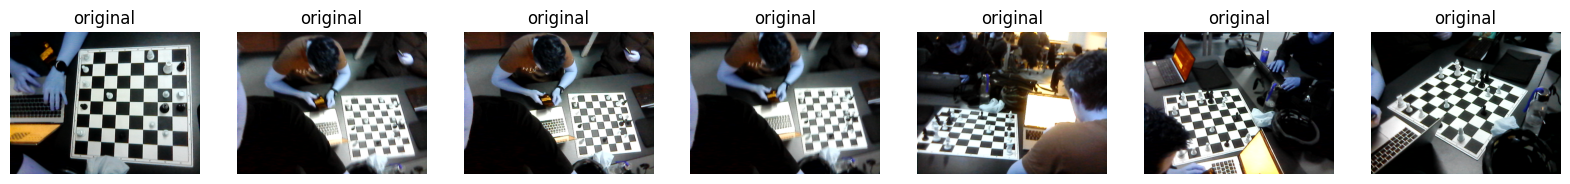

In [148]:
show_imgs("original")

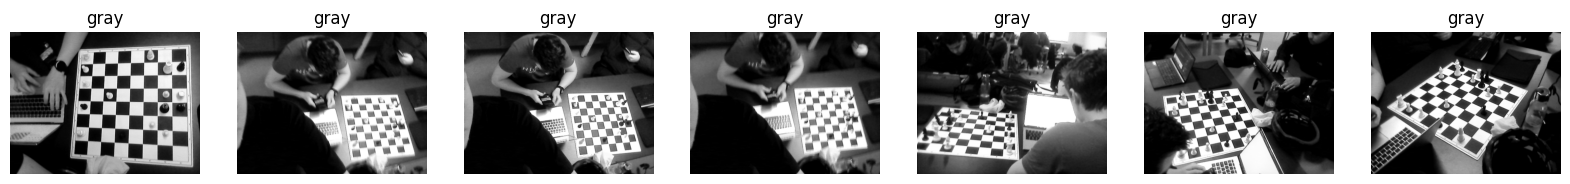

In [149]:
show_imgs("gray")

In [150]:
# find chessboard corners using cv2.findchessboardcorners
# corners = [cv2.findChessboardCorners(img, (9, 6), None) for img in imgs["gray"]]
# imgs["corners"] = [cv2.drawChessboardCorners(img, (9, 6), corner, True) for img, corner in zip(imgs["original"], corners)]
# show_imgs("corners")


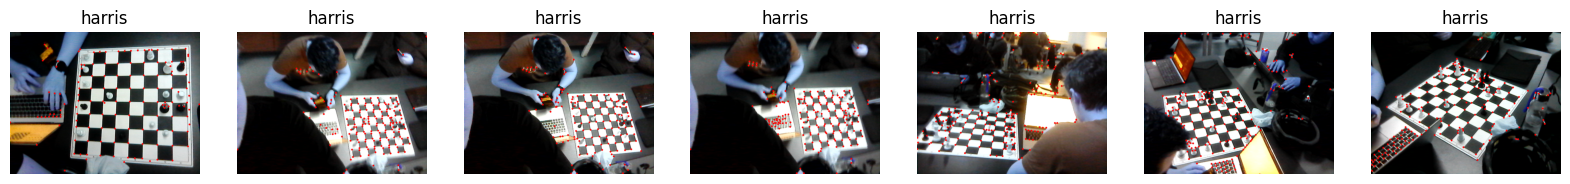

In [151]:
def harris_corners(gray_img):
    dst = cv2.cornerHarris(gray_img, 2, 3, 0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst, None)

    # find centroids
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray_img, np.float32(centroids), (5, 5), (-1, -1), criteria)

    return corners

other_data["corners"] = [harris_corners(img.copy()) for img in imgs["gray_blur"]]

imgs["harris"] = [img.copy() for img in imgs["original"]]

for img, corner in zip(imgs["harris"], other_data["corners"]):
    draw_points(img, corner)

show_imgs("harris")

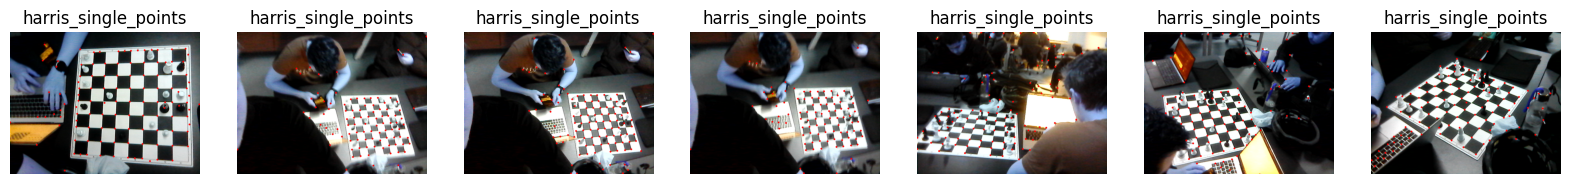

In [152]:
def remove_nearby_points(points, threshold):
    if len(points) == 0:
        return points
    
    new_points = [points[0]]
    for point in points:
        for new_point in new_points:
            if np.linalg.norm(new_point - point) < threshold:
                break
        else: 
            new_points.append(point)

    return new_points

other_data["corners_single_points"] = [remove_nearby_points(corner, 20) for corner in other_data["corners"]]

imgs["harris_single_points"] = [img.copy() for img in imgs["original"]]
for img, corner in zip(imgs["harris_single_points"], other_data["corners_single_points"]):
    draw_points(img, corner)

show_imgs("harris_single_points")

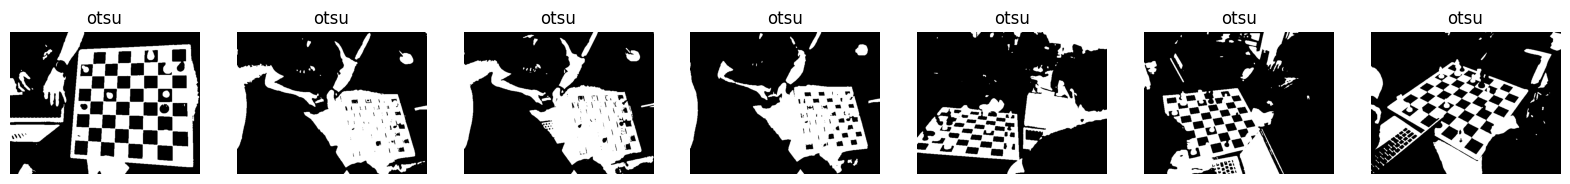

In [153]:
def otsu_binary(gray_img):
    ret2,th2 = cv2.threshold(gray_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th2

imgs["otsu"] = [otsu_binary(img) for img in imgs["gray_blur"]]
show_imgs("otsu")

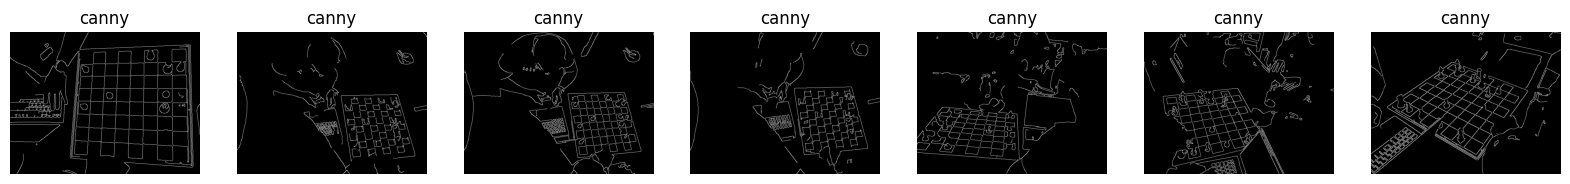

In [154]:
def canny_edges(gray_img, sigma = 0.5):
    v = np.median(gray_img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma*2.5) * v))
    return cv2.Canny(gray_img, 40, 255)

imgs["canny"] = [canny_edges(img) for img in imgs["gray_blur"]]

show_imgs("canny")

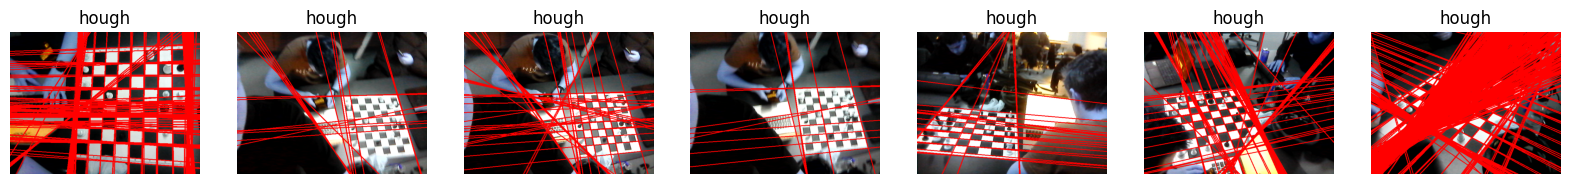

In [155]:
def hough_lines(canny_img):
    lines = cv2.HoughLines(canny_img, 1, math.pi/180.0, 80, np.array([]), 0, 0)
    if lines is None:
        return []
    return [line[0] for line in lines]

imgs["hough"] = [img.copy() for img in imgs["original"]]
other_data["hough"] = [hough_lines(img) for img in imgs["canny"]]

for img, lines in zip(imgs["hough"], other_data["hough"]):
    draw_algebraic_lines(img, lines)

show_imgs("hough")

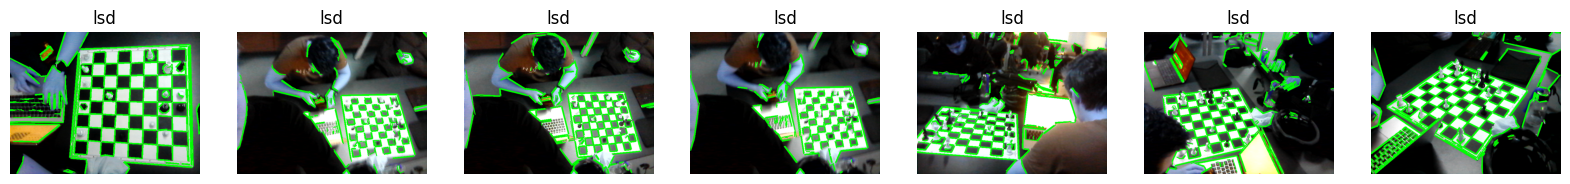

In [156]:
def lsd_lines(canny_img):
    lsd = cv2.createLineSegmentDetector(0)
    lines = lsd.detect(canny_img)[0]
    if lines is None:
        return []
    return [line[0] for line in lines]

imgs["lsd"] = [img.copy() for img in imgs["original"]]

other_data["lsd"] = [lsd_lines(img) for img in imgs["canny"]]
for img, lines in zip(imgs["lsd"], other_data["lsd"]):
    for line in lines:
        x1, y1, x2, y2 = line
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

show_imgs("lsd")

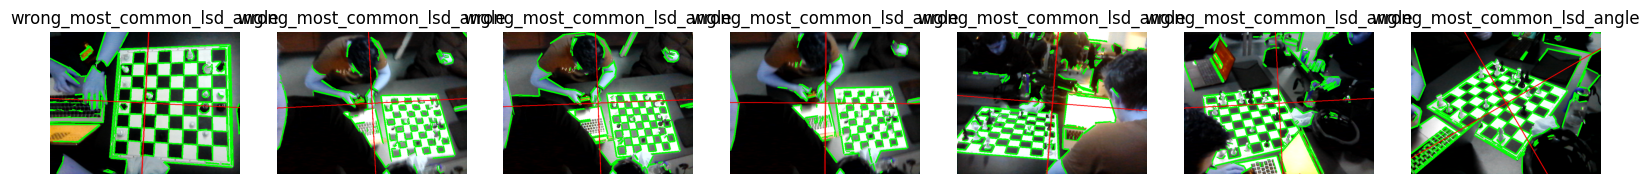

In [157]:
# get line angle in degrees always between 0 and 180 degrees positive
def get_line_angle(line):
    x1, y1, x2, y2 = line
    if x1 == x2:
        return 90
    angle = math.degrees(math.atan((y2 - y1) / (x2 - x1)))
    if angle < 0:
        angle += 180
    return angle

# def get_most_common_angle_90_degrees(angles, angle_threshold = 5):
#     angles = [int(angle % 90) for angle in angles]
# 
#     set_angles = set(angles)
#     # find the most common angle within the threshold
#     most_angles = 0
#     max_count = 0
#     for angle in set_angles:
#         # count this angle and any between it and the threshold
#         count = 0
#         for a in range(angle - angle_threshold, angle + angle_threshold + 1):
#             count += angles.count(a%90)
#             
#         if count > max_count:
#             max_count = count
#             most_angles = angle
# 
#     return most_angles

def get_most_common_angle_90_degrees(angles, angle_threshold = 5):
    angles = sorted([angle % 90 for angle in angles])

    # get range including the most angles
    # the range is any angle +- the threshold
    # the angle does not have to be in the list
    lower_angle = angles[0]
    upper_angle = angles[-1]
    max_count = 0
    for i, a in enumerate(angles):
        count = 0
        for j in range(i, i + len(angles)):
            add = j//len(angles) * 90
            if angles[j % len(angles)] + add - a > angle_threshold*2:
                break

            upper_angle = angles[j % len(angles)] + add
            count = j - i + 1

        if count > max_count:
            max_count = count
            lower_angle = a
        
        if count == len(angles):
            break

    return (lower_angle + upper_angle) / 2

other_data["line_angles"] = [[get_line_angle(line) for line in lines] for lines in other_data["lsd"]]
other_data["wrong_most_common_lsd_angle"] = [get_most_common_angle_90_degrees(angles) for angles in other_data["line_angles"]]

imgs["wrong_most_common_lsd_angle"] = [img.copy() for img in imgs["lsd"]]
for img, angle in zip(imgs["wrong_most_common_lsd_angle"], other_data["wrong_most_common_lsd_angle"]):
    center = (img.shape[1]//2, img.shape[0]//2)
    for i in range(4):
        draw_line_from_point_at_angle(img, center, angle + i * 90, (0, 0, 255))
    
show_imgs("wrong_most_common_lsd_angle")

(90.60003138483042, 92.9332014007897)
(78.04467575831636, 75.94213107843667)
(175.17437033271634, 76.16497997096423)
(174.81221518064513, 78.67494833348547)
(4.904602950269261, 6.64916880753357)
(172.18616584788435, 169.32051930240698)
(141.0596270495206, 24.09627424826367)


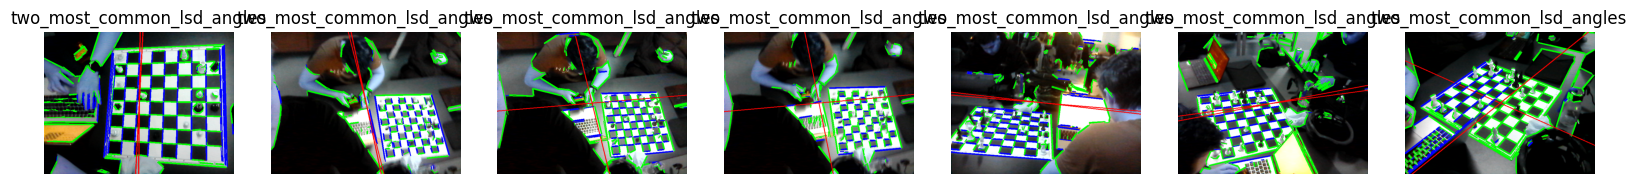

In [168]:
def most_common_range(sorted_floats, threshold):
    # get range including the most floats
    # the range is any float +- the threshold
    # the float does not have to be in the list
    lower_index = 0
    upper_index = len(sorted_floats) - 1
    max_count = 0
    for i, f in enumerate(sorted_floats):
        count = 0
        for j in range(i, i + len(sorted_floats)):
            add = j//len(sorted_floats) * 360
            if sorted_floats[j % len(sorted_floats)] + add - f > threshold*2:
                break

            count = j - i + 1

        if count > max_count:
            max_count = count
            lower_index = i
            upper_index = count + i - 1
        
        if count == len(sorted_floats):
            break

    return lower_index, upper_index


def get_two_most_common_angles(angles, angle_threshold = 2, min_angle_diff = 10):
    angles = sorted([angle % 180 for angle in angles])

    l, u = most_common_range(angles, angle_threshold)
    
    e = u if u < len(angles) else len(angles)

    r = angles[l: e]
    del angles[l: e]

    if u >= len(angles):
        r += [angle + 180 for angle in angles[:u % len(angles)]]
        del angles[:u % len(angles)]

    first_angle = sum(r) / len(r)

    l, u = most_common_range(angles, angle_threshold)

    e = u if u < len(angles) else len(angles)

    r = angles[l: e]

    if u >= len(angles):
        r += [angle + 180 for angle in angles[:u % len(angles)]]

    second_angle = sum(r) / len(r)

    return first_angle % 180, second_angle % 180

other_data["two_most_common_lsd_angles"] = [get_two_most_common_angles(angles) for angles in other_data["line_angles"]]

imgs["two_most_common_lsd_angles"] = [img.copy() for img in imgs["lsd"]]
for img, angles in zip(imgs["two_most_common_lsd_angles"], other_data["two_most_common_lsd_angles"]):
    center = (img.shape[1]//2, img.shape[0]//2)
    for angle in angles:
        draw_line_from_point_at_angle(img, center, angle+90, (0, 0, 255))


# draw lines withing the threshold of the most common angle
for img, lsd, angles, most_common_angle in zip(imgs["two_most_common_lsd_angles"], other_data["lsd"], other_data["line_angles"], other_data["two_most_common_lsd_angles"]):
    print(most_common_angle)
    for line, angle in zip(lsd, angles):
        if abs(angle - most_common_angle[0]) < 5:
            x1, y1, x2, y2 = line
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

show_imgs("two_most_common_lsd_angles")



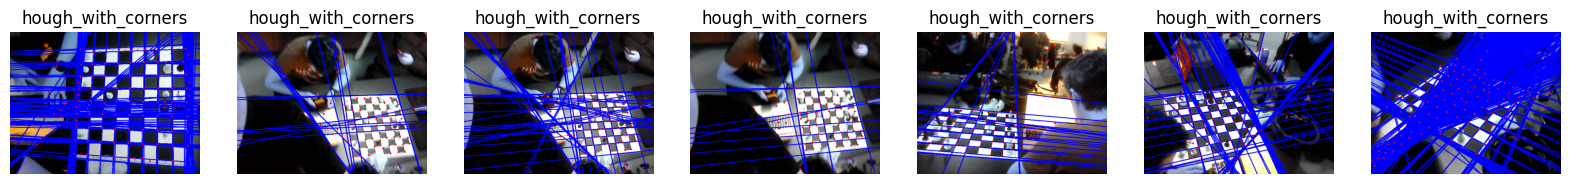

In [159]:
imgs["hough_with_corners"] = [img.copy() for img in imgs["original"]]
for img, lines, corners in zip(imgs["hough_with_corners"], other_data["hough"], other_data["corners_single_points"]):
    draw_algebraic_lines(img, lines, color=(255, 0, 0))
    draw_points(img, corners)

show_imgs("hough_with_corners")

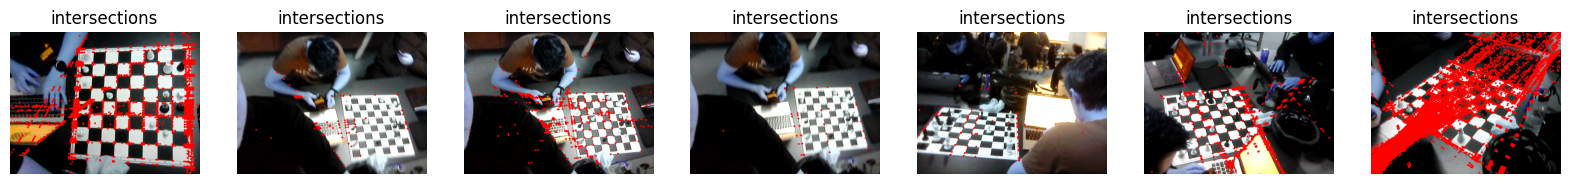

In [160]:
# find intersections between lines

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [math.cos(theta1), math.sin(theta1)],
        [math.cos(theta2), math.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    try:
        x0, y0 = np.linalg.solve(A, b)
        x0, y0 = int(x0), int(y0)
        return (x0, y0)
    except np.linalg.LinAlgError:
        return None

def find_intersections(lines):
    intersections = []
    for i, line1 in enumerate(lines):
        for line2 in lines[i+1:]:
            intersection_point = intersection(line1, line2)
            if intersection_point is not None:
                intersections.append(intersection_point)
    return intersections

other_data["intersections"] = [find_intersections(lines) for lines in other_data["hough"]]

imgs["intersections"] = [img.copy() for img in imgs["original"]]
for img, intersections in zip(imgs["intersections"], other_data["intersections"]):
    draw_points(img, intersections)

show_imgs("intersections")

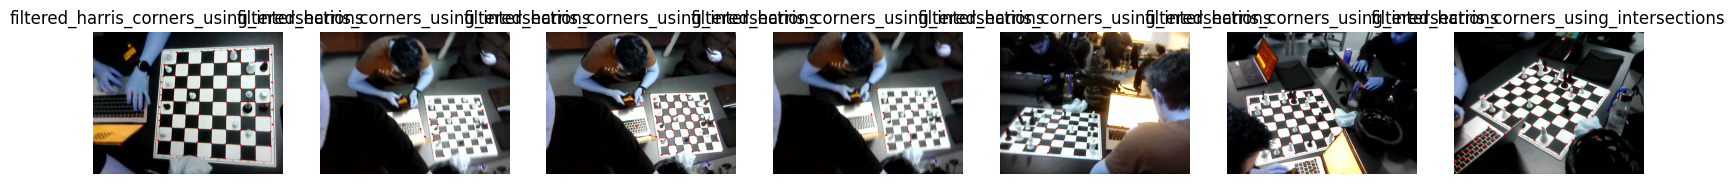

In [161]:
def filter_harris_corners_using_intersections(harris, intersections, margin = 10):
    filtered_corners = []
    for corner in harris:
        for intersection in intersections:
            if abs(corner[0] - intersection[0]) < margin and abs(corner[1] - intersection[1]) < margin:
                filtered_corners.append(corner)
                break
    return filtered_corners

other_data["filtered_harris_corners_using_intersections"] = [filter_harris_corners_using_intersections(harris, intersections) for harris, intersections in zip(other_data["corners_single_points"], other_data["intersections"])]

imgs["filtered_harris_corners_using_intersections"] = [img.copy() for img in imgs["original"]]
for img, corners in zip(imgs["filtered_harris_corners_using_intersections"], other_data["filtered_harris_corners_using_intersections"]):
    draw_points(img, corners)

show_imgs("filtered_harris_corners_using_intersections")

In [162]:
def get_harris_points_for_line(line, harris_corners, margin = 5):
    rho, theta = line
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a*rho
    y0 = b*rho
    p1 = np.array([x0 + 1000*(-b), y0 + 1000*(a)])
    p2 = np.array([x0 - 1000*(-b), y0 - 1000*(a)])

    points = []
    combined_dist = 0
    for i, corner in enumerate(harris_corners):
        p3 = np.array(corner)
        d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        if d < margin:
            combined_dist += d
            points.append(i)
    
    return combined_dist, points

other_data["corner_points_for_line"] = [[get_harris_points_for_line(line, corners) for line in lines] for lines, corners in zip(other_data["hough"], other_data["filtered_harris_corners_using_intersections"])]

for corners in other_data["corner_points_for_line"]:
    print(corners)

[(6.363491239655048, [0, 16, 24, 33, 58, 75, 84, 94]), (1.3187794402790085, [30, 31, 32, 33, 34, 35, 36, 37, 38]), (3.345855712890625, [6, 12, 21, 37, 47, 63, 79, 89, 98]), (10.57405506800818, [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]), (4.005540109770178, [5, 15, 20, 36, 46, 62, 78, 87, 97]), (5.413557968415118, [7, 14, 26, 35, 45, 61, 77, 86, 96]), (4.125982223448591, [20, 21, 22, 23, 24, 25, 26, 27]), (4.121602512638965, [82, 83, 84, 85, 86, 87, 89, 90, 91]), (0, []), (14.902752083427492, [10, 29, 41, 54, 71]), (3.4262398981476, [1]), (9.101119757941195, [10, 29, 41, 54]), (4.7517943265004146, [9, 18, 23, 30, 43, 57, 74, 83, 93]), (1.806848290229158, [1]), (7.59753837836902, [1, 28, 53]), (16.263315508782263, [0, 42, 43, 44, 45, 46, 47, 48, 49, 50]), (9.023835825484712, [1, 28, 53]), (7.35687255859375, [4, 13, 38, 48, 64, 80, 90, 99]), (0, []), (10.846716303541877, [56, 57, 58, 59, 60, 61, 62, 63, 64, 65]), (11.200442889001124, [10, 29, 41]), (9.89724741994356, [11, 12, 13, 14, 15, 1

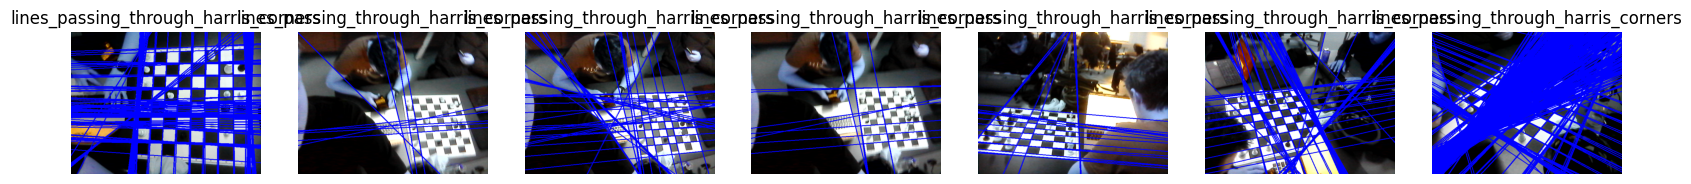

In [163]:
def lines_passing_through_harris_corners(lines, harris_corners):
    lines_passing_through_harris_corners = []
    for line in lines:
        dist, points = get_harris_points_for_line(line, harris_corners)
        if len(points) > 0:
            lines_passing_through_harris_corners.append((line, dist, points))
    return lines_passing_through_harris_corners

other_data["lines_passing_through_harris_corners"] = [lines_passing_through_harris_corners(lines, corners) for lines, corners in zip(other_data["hough"], other_data["filtered_harris_corners_using_intersections"])]

imgs["lines_passing_through_harris_corners"] = [img.copy() for img in imgs["original"]]
for img, lines in zip(imgs["lines_passing_through_harris_corners"], other_data["lines_passing_through_harris_corners"]):
    draw_algebraic_lines(img, [line[0] for line in lines], color=(255, 0, 0))

show_imgs("lines_passing_through_harris_corners")

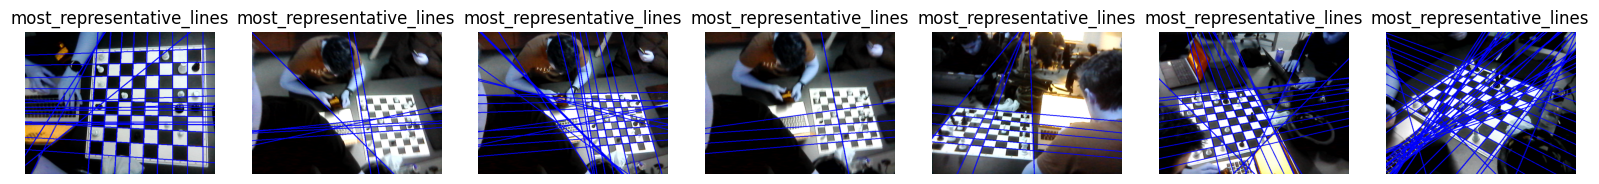

In [164]:
def most_representative_lines_indexes(corner_points_for_line):
    indexed = [(i, *item) for i, item in enumerate(corner_points_for_line)]
    # remove lines that have no harris points or only one harris point
    remove_empty = [item for item in indexed if len(item[2]) > 1]
    sorte = sorted(remove_empty, key=lambda x: len(x[2]), reverse=True)

    if len(sorte) == 0:
        print("no lines found")
        exit()

    # find lines that have the most harris points, without having any other line with more than 1 point in common
    # if there are multiple lines with the same amount of points, choose the one with the smallest distance to the harris points
    most_representative_lines = [sorte[0][0]]
    for i, distance,  harris_points in sorte:
        add = True
        for line in most_representative_lines:
            if np.intersect1d(harris_points, corner_points_for_line[line][1]).size > 1:
                add = False
                break

        if add:
            most_representative_lines.append(i)

    return most_representative_lines

other_data["most_representative_lines_indexes"] = [most_representative_lines_indexes(corner_points_for_line) for corner_points_for_line in other_data["corner_points_for_line"]]
other_data["most_representative_lines"] = [[lines[i] for i in indexes] for lines, indexes in zip(other_data["hough"], other_data["most_representative_lines_indexes"])]

imgs["most_representative_lines"] = [img.copy() for img in imgs["original"]]

for img, lines in zip(imgs["most_representative_lines"], other_data["most_representative_lines"]):
    draw_algebraic_lines(img, lines, color=(255, 0, 0))

show_imgs("most_representative_lines")

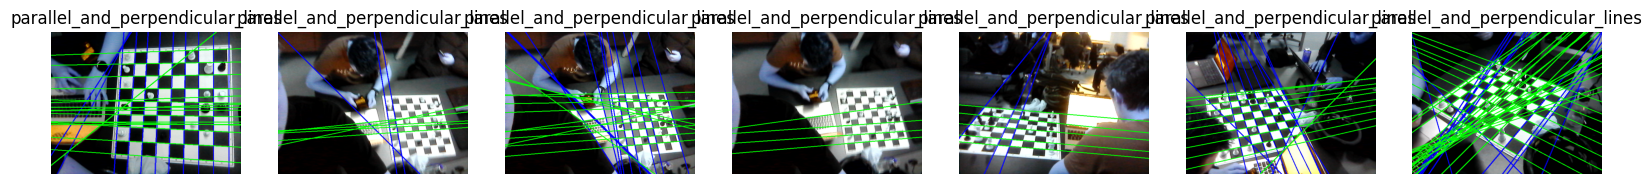

In [165]:
def remove_non_parallel_lines(lines, margin = 1):
    # remove lines that are not parallel to at least one other line
    parallel = []
    for i, line in enumerate(lines):
        rho, theta = line
        for other_line in lines:
            if np.array_equal(line, other_line):
                continue

            other_rho, other_theta = other_line
            if abs(theta - other_theta) < margin:
                parallel.append(i)
                break

    return [lines[i] for i in parallel]

def split_lines_to_parallel_and_perpendicular(lines):
    parallel = []
    perpendicular = []
    for line in lines:
        rho, theta = line
        if abs(theta - math.pi/2) < math.pi/4:
            perpendicular.append(line)
        else:
            parallel.append(line)
    return parallel, perpendicular

other_data["parallel_lines"] = [remove_non_parallel_lines(lines) for lines in other_data["most_representative_lines"]]
other_data["parallel_and_perpendicular_lines"] = [split_lines_to_parallel_and_perpendicular(lines) for lines in other_data["parallel_lines"]]

imgs["parallel_and_perpendicular_lines"] = [img.copy() for img in imgs["original"]]
for img, lines in zip(imgs["parallel_and_perpendicular_lines"], other_data["parallel_and_perpendicular_lines"]):
    draw_algebraic_lines(img, lines[0], color=(255, 0, 0))
    draw_algebraic_lines(img, lines[1], color=(0, 255, 0))

show_imgs("parallel_and_perpendicular_lines")